# Toxicity Classification:

### 1. Business Problem:

**Source:** https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification<br><br>
**Description:** https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/description<br><br>
**Problem Statement:** Given a comment made by the user, predict the toxicity of the comment.<br><br>

### 2. Machine Learning Problem Formulation:

#### 2.1 Data: <br>

- Source: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data
- We have one single csv file for training and one cvs file to test.
- Columns in train data:
    - Comment_text: This is the data in string format which we have to use to find the toxicity.
    - target: Target values which are to be predicted (has values between 0 and 1)
    - Data also has additional toxicity subtype attributes: (Model does not have to predict these)
        - severe_toxicity
        - obscene
        - threat
        - insult
        - identity_attack
        - sexual_explicit
    - Comment_text data also has identity attributes carved out from it, some of which are:
        - male
        - female
        - homosexual_gay_or_lesbian
        - christian
        - jewish
        - muslim
        - black
        - white
        - asian
        - latino
        - psychiatric_or_mental_illness
    - Apart from above features the train data also provides meta-data from jigsaw like:
        - toxicity_annotator_count
        - identity_anotator_count
        - article_id
        - funny
        - sad
        - wow
        - likes
        - disagree
        - publication_id
        - parent_id
        - article_id
        - created_date
        

#### 2.2 Example Datapoints and Labels:<br>

**Comment:** i'm a white woman in my late 60's and believe me, they are not too crazy about me either!!<br><br>

- Toxicity Labels: All 0.0
- Identity Mention Labels: female: 1.0, white: 1.0 (all others 0.0)

**Comment:** Why would you assume that the nurses in this story were women?<br><br>

- Toxicity Labels: All 0.0
- Identity Mention Labels: female: 0.8 (all others 0.0)

**Comment:** Continue to stand strong LGBT community. Yes, indeed, you'll overcome and you have.<br><r>

- Toxicity Labels: All 0.0
- Identity Mention Labels: homosexual_gay_or_lesbian: 0.8, bisexual: 0.6, transgender: 0.3 (all others 0.0)



#### 2.3 Type of Machine Learning Problem:<br>

We have to predict the toxicity level(target attribute). The values range from 0 to 1 inclusive. This is a regression problem. It can also be treated as a classification problem if we take every value below 0.5 to be non-toxic and above it to be toxic, we would then get a binary classification problem.



#### 2.4 Performance Metric:

The competition will use ROC_AUC as the metric after converting the numeric target variable into a categorical variable by using a threshold of 0.5. Any comment above 0.5 will be assumed to be toxic and below it non-toxic. For our training and evaluation we will use the MSE(Mean Squared Error).<br>
More on evaluation: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation



#### 2.5 Machine Learning Objectives and Constraints:<br>

**Objectives:** Predict the toxicity of a comment made by the user. (0 -> not toxic, 1 -> highest toxicity level)

**Constraints:**
- The model should be fast to predict the toxicity rating.
- Interpretability is not needed.

## Importing Libraries:

In [7]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import gensim
import string
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import Dropout
# from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import Embedding
import warnings
# from keras import backend as K
warnings.filterwarnings("ignore")
# K.tensorflow_backend._get_available_gpus()

In [ ]:
tf.config.list_physical_devices('GPU') 

In [9]:
tf.test.gpu_device_name()

2023-02-26 17:32:19.328519: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


''

## Reading Data:


In [10]:
train_df = pd.read_csv('train.csv', index_col='id', engine='python')
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [ ]:
test_df = pd.read_csv('test.csv', index_col='id', engine='python')
test_df.head()

In [12]:
train_df.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,0.034393,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,0.167900,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


**Looking at count values of asian,atheist etc columns we see that there are a lot of Null values present, but this is OK as we are only supposed to use 'comment_text' column so dealing with these is not really necessary here.**

array([[<AxesSubplot:title={'center':'target'}>]], dtype=object)

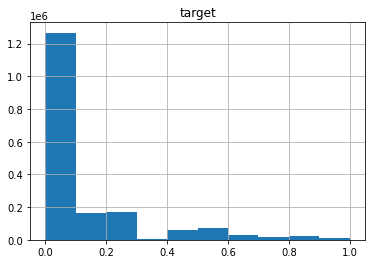

In [18]:
train_df.hist(column='target',bins=10)